# 千葉県 自転車盗難データ分析レポート

このレポートでは、千葉県警のオープンデータを利用し、  
過去1年間に発生した自転車盗難の傾向を分析した。

- どの地域で盗難が多いか  
- どの時間帯に多いか  
- 月ごとの発生件数  
- 鍵の有無で発生率はどう変わるか  
- 被害者の特徴（職業など）

などをPython（pandas / matplotlib）でまとめた。


In [3]:
import pandas as pd

df = pd.read_csv("jitensha.csv")
df.head()

,罪名,手口,管轄警察署（発生地）,管轄交番・駐在所（発生地）,市区町村コード（発生地）,都道府県（発生地）,市区町村（発生地）,町丁目（発生地）,発生年月日（始期）,発生時（始期）,発生場所,発生場所の詳細,被害者の年齢,被害者の職業,施錠関係
0,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240117,23,その他の住宅（３階建て以下共同住宅等）,駐車（輪）場,20歳代,大学生,施錠した
1,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240227,18,駐車（輪）場,駐車（輪）場,10歳代,中学生,施錠せず
2,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240528,20,駐車（輪）場,駐車（輪）場,40歳代,その他,施錠した
3,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240627,21,駐車（輪）場,駐車（輪）場,10歳代,中学生,施錠せず
4,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240917,14,その他,その他,20歳代,その他,施錠せず


## 基本情報

データの行数・列数、欠損の有無などを確認する。


In [4]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9943 entries, 0 to 9942
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   罪名             9943 non-null   object 
 1   手口             9943 non-null   object 
 2   管轄警察署（発生地）     9943 non-null   object 
 3   管轄交番・駐在所（発生地）  9938 non-null   object 
 4   市区町村コード（発生地）   9942 non-null   float64
 5   都道府県（発生地）      9942 non-null   object 
 6   市区町村（発生地）      9942 non-null   object 
 7   町丁目（発生地）       9921 non-null   object 
 8   発生年月日（始期）      9943 non-null   object 
 9   発生時（始期）        9943 non-null   object 
 10  発生場所           9943 non-null   object 
 11  発生場所の詳細        9943 non-null   object 
 12  被害者の年齢         9943 non-null   object 
 13  被害者の職業         9943 non-null   object 
 14  施錠関係           9943 non-null   object 
dtypes: float64(1), object(14)
memory usage: 1.1+ MB


罪名                0
手口                0
管轄警察署（発生地）        0
管轄交番・駐在所（発生地）     5
市区町村コード（発生地）      1
都道府県（発生地）         1
市区町村（発生地）         1
町丁目（発生地）         22
発生年月日（始期）         0
発生時（始期）           0
発生場所              0
発生場所の詳細           0
被害者の年齢            0
被害者の職業            0
施錠関係              0
dtype: int64

## 市区町村ごとの盗難件数（多い順）


In [24]:
# 市区町村別件数のトップ10
city_counts = df.groupby('市区町村（発生地）').size().sort_values(ascending=False).head(10)

# Series → DataFrame化
city_counts = city_counts.reset_index(name='件数')
city_counts = city_counts.rename(columns={'市区町村（発生地）': '市区町村'})

# インデックスを消して表示
city_counts.style\
    .set_caption("市区町村別 自転車盗難件数（上位10件）")\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th.row_heading', 'props': 'display: none;'},
        {'selector': 'th.blank', 'props': 'display: none;'}
    ])


,市区町村,件数
0,船橋市,1263
1,市川市,872
2,柏市,691
3,松戸市,678
4,千葉市中央区,656
5,八千代市,458
6,習志野市,450
7,浦安市,435
8,野田市,367
9,千葉市稲毛区,334


## 月別の盗難件数


In [21]:
monthly_counts = df.groupby('月').size().reset_index(name='件数')

# 月を整数に変換
monthly_counts['月'] = monthly_counts['月'].astype(int)

# インデックスを消して表示
monthly_counts.style\
    .set_caption("月別自転車盗難件数")\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th.row_heading', 'props': 'display: none;'},
        {'selector': 'th.blank', 'props': 'display: none;'}
    ])


,月,件数
0,1,620
1,2,569
2,3,681
3,4,761
4,5,813
5,6,826
6,7,1027
7,8,943
8,9,984
9,10,956


## 鍵の有無による盗難件数の比較（Impact）


In [20]:
lock_counts = df.groupby('施錠関係').size().sort_values(ascending=False)

# Series → DataFrame
lock_counts = lock_counts.reset_index(name='件数')
lock_counts = lock_counts.rename(columns={'施錠関係': '施錠状況'})

# インデックス非表示で表を表示
lock_counts.style\
    .set_caption("施錠状況別 自転車盗難件数")\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th.row_heading', 'props': 'display: none;'},
        {'selector': 'th.blank', 'props': 'display: none;'}
    ])


,施錠状況,件数
0,施錠せず,6781
1,施錠した,3162


## 発生時間帯の傾向


In [19]:
time_counts.style\
    .set_caption("発生時別 自転車盗難件数（0〜23時 順）")\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th.row_heading', 'props': 'display: none;'},
        {'selector': 'th.blank', 'props': 'display: none;'}
    ])


,発生時,件数
0,0,167
1,1,74
2,2,32
3,3,23
4,4,30
5,5,113
6,6,333
7,7,919
8,8,675
9,9,411


## 被害者の職業別の件数（上位10）


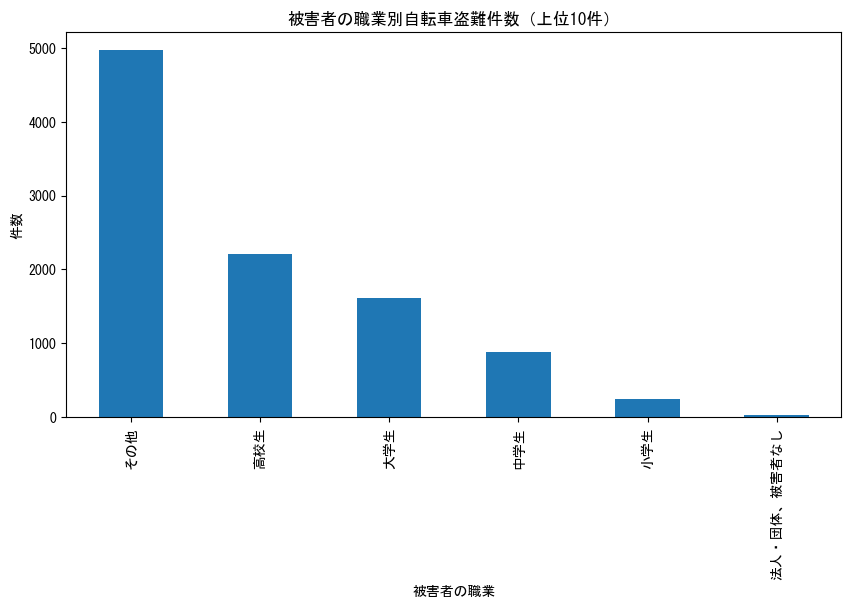

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'MS Gothic'

occupation_counts = df['被害者の職業'].value_counts().head(10)
occupation_counts.plot(kind='bar', figsize=(10,5))
plt.xlabel('被害者の職業')
plt.ylabel('件数')
plt.title('被害者の職業別自転車盗難件数（上位10件）')
plt.show()
